In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [3]:
from torchvision import datasets

data_path = "data_unver/07/"
# we can pass also tranformers when bring the data
# datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(cifar10)

50000

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
img, label = cifar10[99]

In [6]:
print(img, label, class_names[label])

<PIL.Image.Image image mode=RGB size=32x32 at 0x7F24A0575EE0> 1 automobile


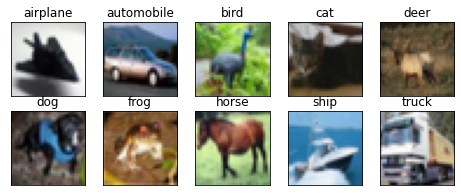

In [7]:
fig = plt.figure(figsize=(8, 3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

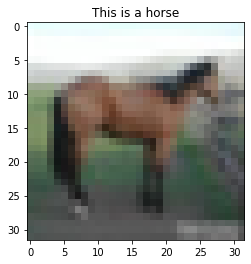

In [8]:
import random
img_rdn = random.choice(range(0, 50000))

img, label = cifar10[img_rdn]

plt.imshow(img)
plt.title(f"This is a {class_names[label]}")
plt.show()

In [9]:
import random

random.choice(range(0, 50000))

28483

## Dataset transforms

For data augmentation using transformers or albumantations, please check the link: https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8

In [10]:
from torchvision import transforms

dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [11]:
to_tensor = transforms.PILToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [13]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())
tensor_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data_unver/07/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [14]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [15]:
img_t.shape

torch.Size([3, 32, 32])

In [16]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

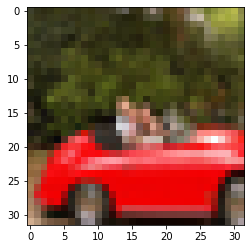

In [17]:
plt.imshow(img_t.permute(1, 2, 0))  # C x H x W to H x W x C
plt.show()

`permute` change the order of the dimensions: dim_1, dim_2, dim_0.

## Normalizing data

In [18]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [19]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

Recall that view(3, -1) keeps the three channels and merges all the remaining dimensions into one, figuring out the appropriate size. Here our 3 x 32 x 32 image is transformed into a 3 x 1024 vector, and then the mean is taken over the 1024 elements of each channel.

In [21]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [22]:
# using transforms
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [23]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


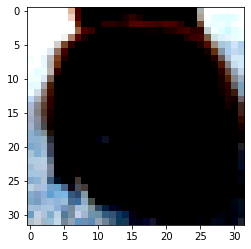

In [26]:
img_t, _ = transformed_cifar10[999]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Distinguishing birds from airplanes

In [27]:
# building the dataset
# we could create a subclass of Dataset
# but on this dataset is not necessary
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [29]:
import torch.nn as nn

In [30]:
n_out = 2
model = nn.Sequential(
    nn.Linear(3072, 512,),
    nn.Tanh(),
    nn.Linear(512, n_out),
)